# Analyzing Short-Term Hospital Readmissions Using the MIMIC-III Dataset

## Data Visualization 

The purpose of this notebook is to provide visualizations and key data points using the pre-processed MIMIC-III data 

Our data set has been filtered for patients of age 18-88, given a Charlson comorbidity score for each patient, added length of stay, and a 30-day readmission flag. We intend to breakdown how this re-admission breaks down by available demographic and comorbidity data.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '../data/pre-processed/'
figures = '../reports/figures/'

In [27]:
patient_admissions = pd.read_pickle(data_path + 'patient_admissions')
patient_admissions.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,DOB,AGE_AT_ADMISSION,comorbidity_score,LENGTH_OF_STAY,PREV_DISCHTIME,DAYS_TO_READMIT,READMISSION_FLAG
156,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,Medicare,NaN,CATHOLIC,MARRIED,WHITE,M,2025-04-11,76.522930,2.0,10,NaT,NaN,0
157,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,F,2143-05-12,47.843943,4.0,7,NaT,NaN,0
158,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,F,2109-06-21,65.938398,1.0,16,NaT,NaN,0
159,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,Private,NaN,OTHER,MARRIED,WHITE,F,2128-02-22,50.146475,2.0,25,NaT,NaN,0
160,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,EMERGENCY,Medicaid,NaN,OTHER,NaN,WHITE,F,2127-02-27,39.863107,0.0,6,NaT,NaN,0


In [28]:
readmission_rate = patient_admissions['READMISSION_FLAG'].mean() * 100
print(f"\nOverall Readmission Rate (within 30 days): {readmission_rate:.2f}%")


Overall Readmission Rate (within 30 days): 5.78%


/tmp/ipykernel_997229/905339413.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readmission_by_age_bin = patient_admissions.groupby('AGE_BIN')['READMISSION_FLAG'].mean().reset_index()
/tmp/ipykernel_997229/905339413.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=readmission_by_age_bin, x='AGE_BIN', y='READMISSION_RATE', palette='deep')


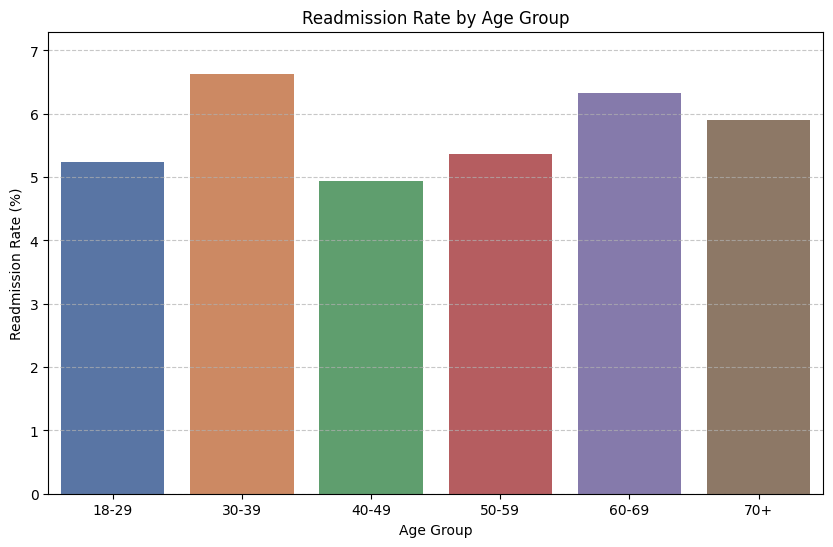

In [34]:
# Create age bins
age_bins = [18, 30, 40, 50, 60, 70, 88]
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+'] 

patient_admissions['AGE_BIN'] = pd.cut(
    patient_admissions['AGE_AT_ADMISSION'],
    bins=age_bins,
    labels=age_labels,
    right=False # right=False means the left edge is inclusive
)

# Calculate readmission rate per age bin
readmission_by_age_bin = patient_admissions.groupby('AGE_BIN')['READMISSION_FLAG'].mean().reset_index()
readmission_by_age_bin['READMISSION_RATE'] = readmission_by_age_bin['READMISSION_FLAG'] * 100

plt.figure(figsize=(10, 6))
sns.barplot(data=readmission_by_age_bin, x='AGE_BIN', y='READMISSION_RATE', palette='deep')
plt.title('Readmission Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Readmission Rate (%)')
plt.ylim(0, readmission_by_age_bin['READMISSION_RATE'].max() * 1.1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We'll want to plot similar plots for many of the categorical columns, like ethnicity, marital status, gender, religion. So let's create a function that will do the repeated steps that we can feed filtered data to.

In [ ]:
def plot_readmission_by_category(df, category_col, title_prefix):
    """
    Plots the readmission rate for different categories of a given column.
    Handles potential categories with very few entries by showing counts.
    """
    # Calculate readmission rate per category
    readmission_by_category = df.groupby(category_col)['READMISSION_FLAG'].agg(['mean', 'count']).reset_index()
    readmission_by_category.rename(columns={'mean': 'READMISSION_RATE', 'count': 'TOTAL_ADMISSIONS'}, inplace=True)
    readmission_by_category['READMISSION_RATE'] = readmission_by_category['READMISSION_RATE'] * 100

    # Sort by readmission rate for better visualization
    readmission_by_category = readmission_by_category.sort_values(by='READMISSION_RATE', ascending=False)

    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=readmission_by_category, x=category_col, y='READMISSION_RATE', palette='deep')

    # Add total admissions count and percentage on top of bars
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
        x_coord = p.get_x()
        category_label = ax.get_xticklabels()[int(x_coord + width/2)].get_text() # Get category from x-tick label
        row_data = readmission_by_category[readmission_by_category[category_col] == category_label].iloc[0]
        total_admissions = row_data['TOTAL_ADMISSIONS']
        readmission_rate = row_data['READMISSION_RATE']
        text_offset = height * 0.02 
        label_text = f'{readmission_rate:.2f}%\nn={total_admissions}'

        ax.text(
            x_coord + width / 2, 
            height + text_offset, 
            label_text,
            ha='center', 
            va='bottom', 
            color='black',
            fontsize=9 
        )

    plt.title(f'Readmission Rate by {title_prefix}', fontsize=16)
    plt.xlabel(title_prefix, fontsize=12)
    plt.ylabel('Readmission Rate (%)', fontsize=12)

    # Adjust y-axis limit to ensure labels are not cut off
    # Find the maximum bar height and add a buffer (e.g., 20% more space)
    max_rate = readmission_by_category['READMISSION_RATE'].max()
    plt.ylim(0, max_rate * 1.2) 

    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() 
    plt.show()

/tmp/ipykernel_997229/41798293.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=readmission_by_category, x=category_col, y='READMISSION_RATE', palette='deep')


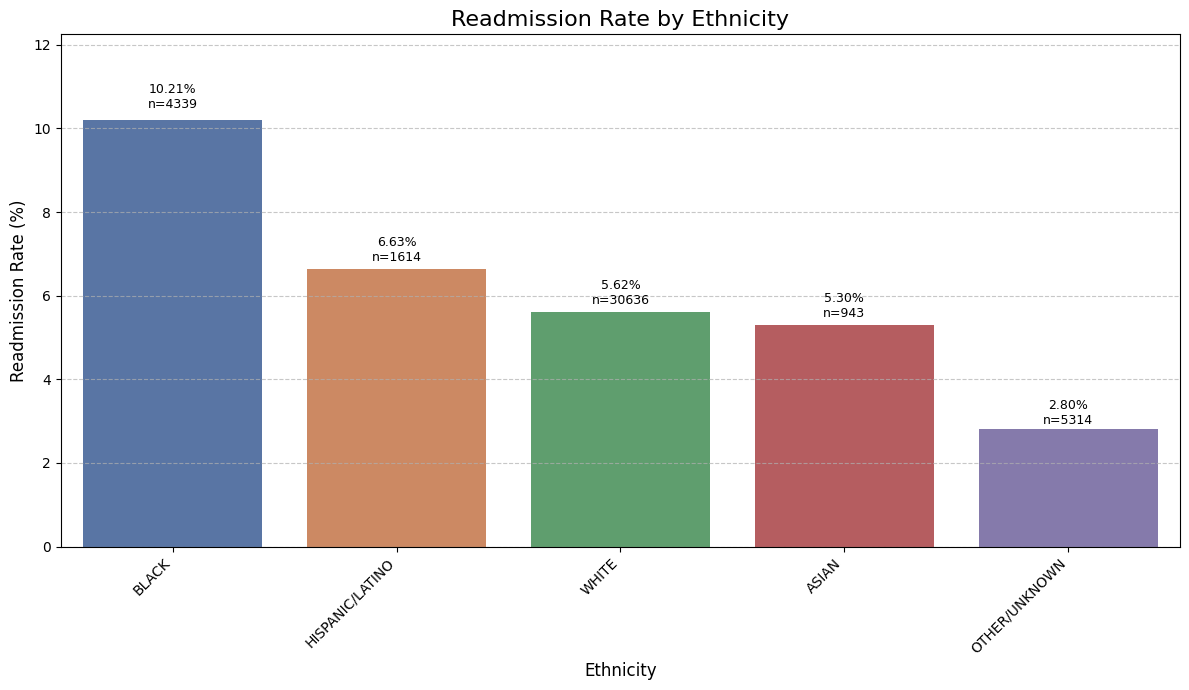

In [33]:
min_ethnicity_count = 50 # Adjust as needed
ethnicity_counts = patient_admissions['ETHNICITY'].value_counts()
major_ethnicities = ethnicity_counts[ethnicity_counts >= min_ethnicity_count].index
ethnicity_set = patient_admissions[patient_admissions['ETHNICITY'].isin(major_ethnicities)]

plot_readmission_by_category(ethnicity_set, 'ETHNICITY', 'Ethnicity')

/tmp/ipykernel_997229/41798293.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=readmission_by_category, x=category_col, y='READMISSION_RATE', palette='deep')


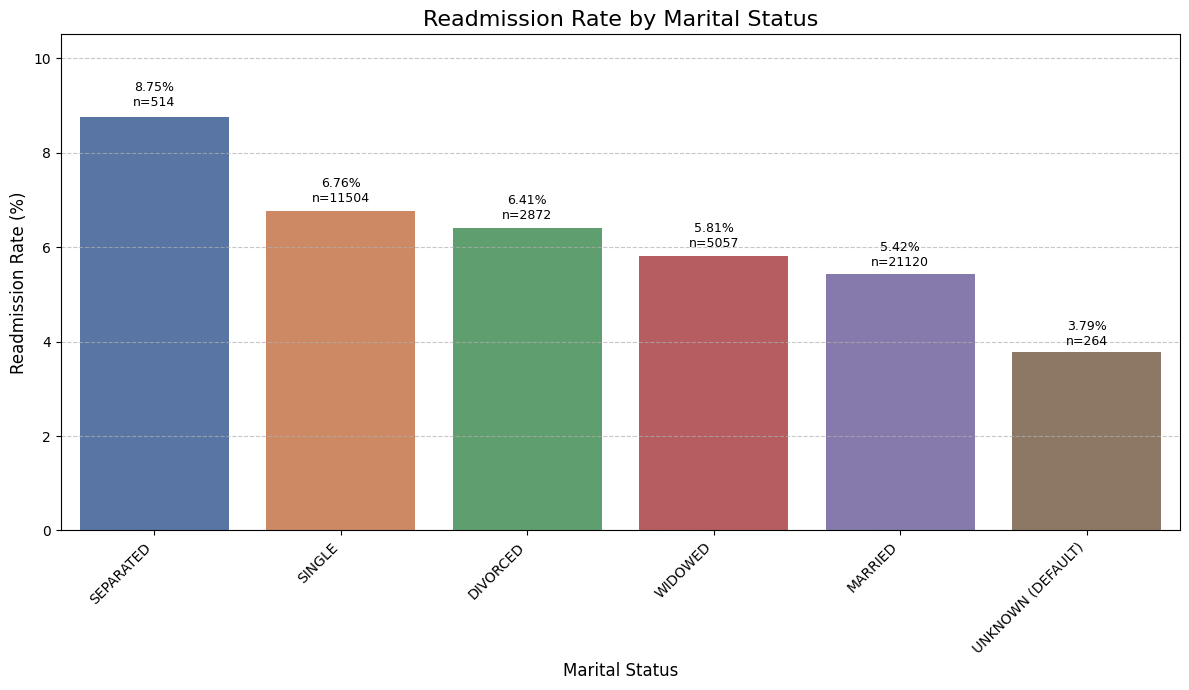

In [35]:
# Filter out categories with very few counts if they skew the plot
min_marital_status_count = 50 # Adjust as needed
marital_status_counts = patient_admissions['MARITAL_STATUS'].value_counts()
major_marital_statuses = marital_status_counts[marital_status_counts >= min_marital_status_count].index
marital_set = patient_admissions[patient_admissions['MARITAL_STATUS'].isin(major_marital_statuses)]

plot_readmission_by_category(marital_set, 'MARITAL_STATUS', 'Marital Status')

/tmp/ipykernel_997229/41798293.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=readmission_by_category, x=category_col, y='READMISSION_RATE', palette='deep')


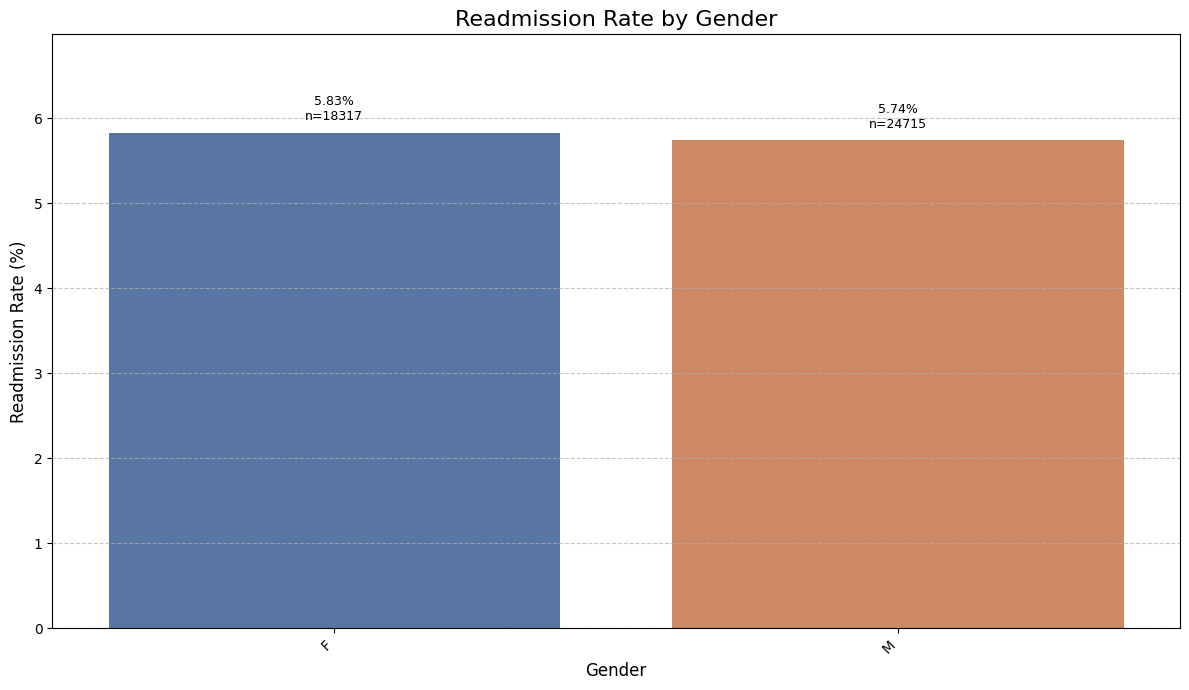

In [36]:
plot_readmission_by_category(patient_admissions, 'GENDER', 'Gender')

/tmp/ipykernel_997229/41798293.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=readmission_by_category, x=category_col, y='READMISSION_RATE', palette='deep')


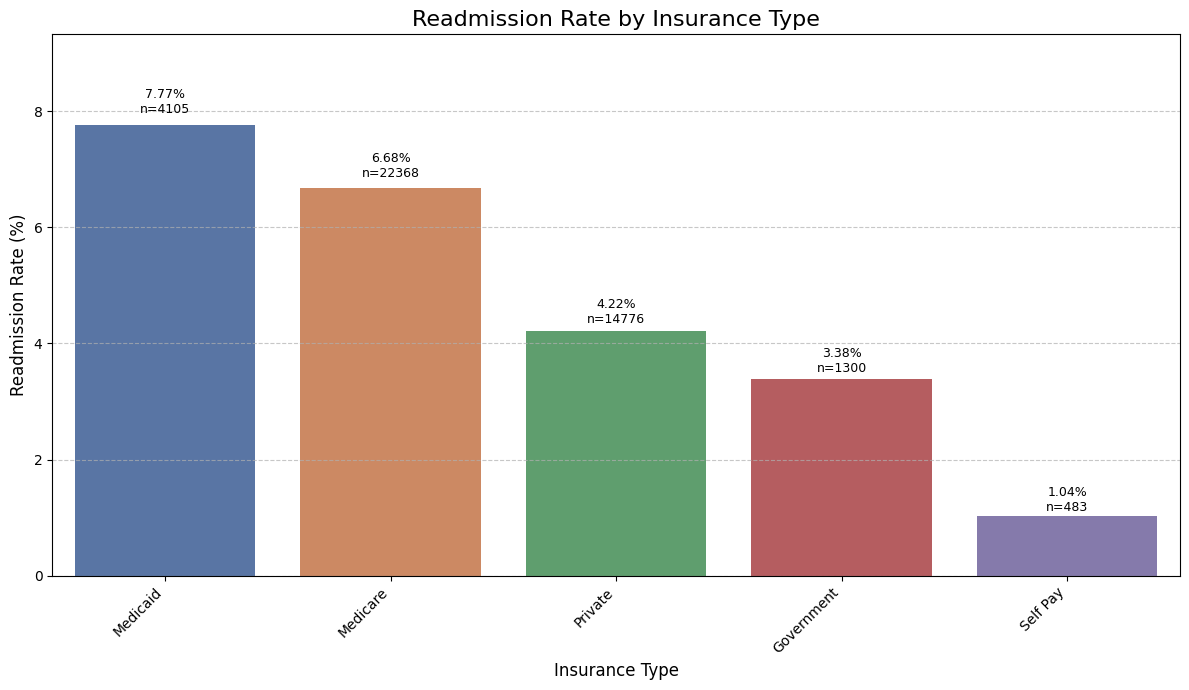

In [38]:
plot_readmission_by_category(patient_admissions, 'INSURANCE', 'Insurance Type')